In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Paths
PROJECT_ROOT = Path("..").resolve()
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "length_of_stay_europe_processed.csv"
FIG_DIR = PROJECT_ROOT / "outputs" / "figures"
TAB_DIR = PROJECT_ROOT / "outputs" / "tables"

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

# Load
df = pd.read_csv(DATA_PATH)

print("Loaded:", DATA_PATH)
print("Rows, cols:", df.shape)
print("Years:", int(df["year"].min()), "to", int(df["year"].max()))
print("Countries:", df["country_code"].nunique())


Loaded: /Users/punarnava/los-europe/data/processed/length_of_stay_europe_processed.csv
Rows, cols: (333, 6)
Years: 2010 to 2021
Countries: 35


In [2]:
# Remove implausible LOS (likely reporting/scaling anomalies)
df = df[(df["los_days"] > 0) & (df["los_days"] < 50)].copy()

print("After QC filter:")
print("Rows:", df.shape[0])
print("LOS range:", df["los_days"].min(), "to", df["los_days"].max())
print("Countries:", df["country_code"].nunique())


After QC filter:
Rows: 328
LOS range: 3.2 to 9.28
Countries: 35


In [3]:
country_names = {
    "AT": "Austria", "BE": "Belgium", "BG": "Bulgaria", "CH": "Switzerland",
    "CY": "Cyprus", "CZ": "Czechia", "DE": "Germany", "DK": "Denmark",
    "EE": "Estonia", "ES": "Spain", "FI": "Finland", "FR": "France",
    "HR": "Croatia", "HU": "Hungary", "IE": "Ireland", "IS": "Iceland",
    "IT": "Italy", "LT": "Lithuania", "LU": "Luxembourg", "LV": "Latvia",
    "MT": "Malta", "NL": "Netherlands", "NO": "Norway", "PL": "Poland",
    "PT": "Portugal", "RO": "Romania", "SE": "Sweden", "SI": "Slovenia",
    "SK": "Slovakia", "UK": "United Kingdom", "MK": "North Macedonia",
}


In [4]:
coverage = df.groupby("year")["country_code"].nunique().sort_values(ascending=False)

BEST_YEAR = int(coverage.index[0])
BEST_YEAR_COUNTRIES = int(coverage.iloc[0])

print("Best coverage year:", BEST_YEAR)
print("Countries in that year:", BEST_YEAR_COUNTRIES)

coverage.head(10)


Best coverage year: 2010
Countries in that year: 33


year
2010    33
2011    33
2012    33
2013    33
2014    33
2015    33
2018    33
2016    32
2017    32
2019    31
Name: country_code, dtype: int64

In [5]:
cross = df[df["year"] == BEST_YEAR].copy()

ranking = (
    cross.groupby("country_code", as_index=False)
    .agg(los_days=("los_days", "mean"))
    .sort_values("los_days", ascending=False)
)

ranking["country"] = ranking["country_code"].map(country_names).fillna(ranking["country_code"]).astype(str)

# Save table
ranking_path = TAB_DIR / f"los_ranking_best_coverage_year_{BEST_YEAR}.csv"
ranking.to_csv(ranking_path, index=False)

print("Saved:", ranking_path)
ranking.head(10)


Saved: /Users/punarnava/los-europe/outputs/tables/los_ranking_best_coverage_year_2010.csv


,country_code,los_days,country
25,PT,8.58,Portugal
27,RS,8.20,RS
5,DE,8.10,Germany
2,CH,7.85,Switzerland
18,LU,7.55,Luxembourg
24,PL,7.30,Poland
1,BE,7.20,Belgium
11,HR,7.16,Croatia
17,LT,7.11,Lithuania
9,FI,7.00,Finland


PosixPath('/Users/punarnava/los-europe/outputs/figures/los_cross_country_2010.png')

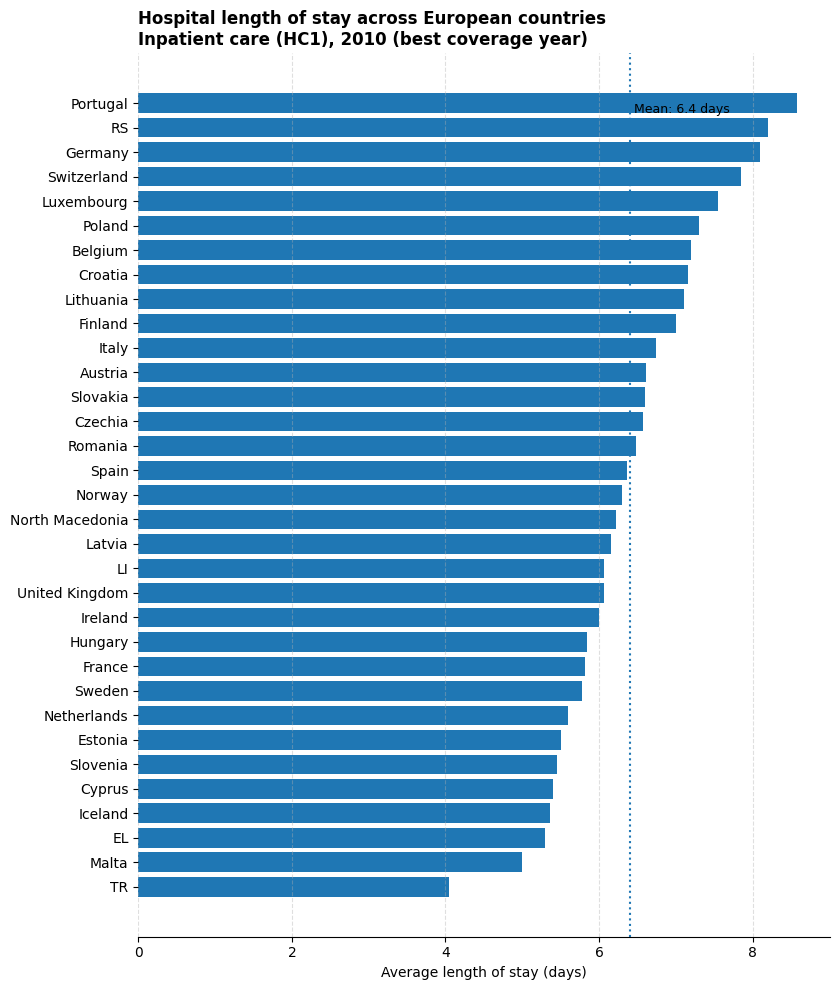

In [6]:
plot_df = ranking.sort_values("los_days").copy()  # ascending for barh bottom->top

plt.figure(figsize=(8.5, 10))
plt.barh(plot_df["country"], plot_df["los_days"])

plt.xlabel("Average length of stay (days)")
plt.title(
    f"Hospital length of stay across European countries\n"
    f"Inpatient care (HC1), {BEST_YEAR} (best coverage year)",
    loc="left",
    fontsize=12,
    weight="bold"
)

plt.grid(axis="x", linestyle="--", alpha=0.4)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

mean_val = plot_df["los_days"].mean()
plt.axvline(mean_val, linestyle=":", linewidth=1.5)
plt.text(mean_val + 0.05, len(plot_df) - 1, f"Mean: {mean_val:.1f} days", fontsize=9, va="top")

plt.tight_layout()

fig_path = FIG_DIR / f"los_cross_country_{BEST_YEAR}.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
fig_path


PosixPath('/Users/punarnava/los-europe/outputs/figures/los_bottom15_2010.png')

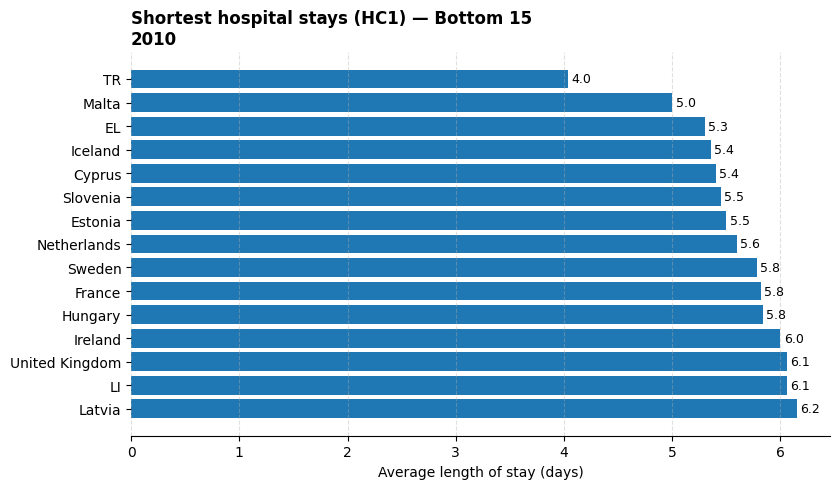

In [7]:
bottom_n = 15
bottom = ranking.sort_values("los_days").head(bottom_n).copy()
bottom = bottom.iloc[::-1]  # reverse for barh (shortest at top looks odd)

plt.figure(figsize=(8.5, 5))
plt.barh(bottom["country"], bottom["los_days"])

plt.xlabel("Average length of stay (days)")
plt.title(
    f"Shortest hospital stays (HC1) — Bottom {bottom_n}\n{BEST_YEAR}",
    loc="left",
    fontsize=12,
    weight="bold"
)

plt.grid(axis="x", linestyle="--", alpha=0.4)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

for i, v in enumerate(bottom["los_days"]):
    plt.text(v + 0.03, i, f"{v:.1f}", va="center", fontsize=9)

plt.tight_layout()

fig_path = FIG_DIR / f"los_bottom{bottom_n}_{BEST_YEAR}.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
fig_path


PosixPath('/Users/punarnava/los-europe/outputs/figures/los_top15_2010.png')

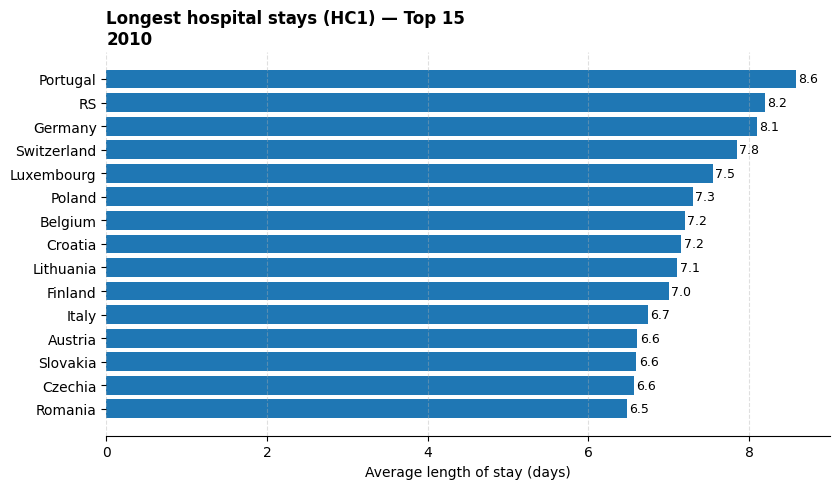

In [8]:
top_n = 15
top = ranking.head(top_n).copy()
top = top.iloc[::-1]

plt.figure(figsize=(8.5, 5))
plt.barh(top["country"], top["los_days"])

plt.xlabel("Average length of stay (days)")
plt.title(
    f"Longest hospital stays (HC1) — Top {top_n}\n{BEST_YEAR}",
    loc="left",
    fontsize=12,
    weight="bold"
)

plt.grid(axis="x", linestyle="--", alpha=0.4)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

for i, v in enumerate(top["los_days"]):
    plt.text(v + 0.03, i, f"{v:.1f}", va="center", fontsize=9)

plt.tight_layout()

fig_path = FIG_DIR / f"los_top{top_n}_{BEST_YEAR}.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
fig_path


PosixPath('/Users/punarnava/los-europe/outputs/figures/los_trends_selected.png')

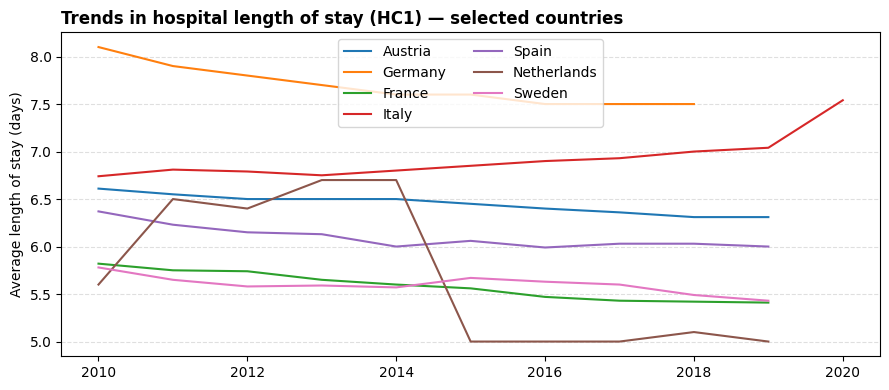

In [9]:
selected = ["Austria", "Germany", "France", "Italy", "Spain", "Netherlands", "Sweden"]
code_for_name = {v: k for k, v in country_names.items()}
selected_codes = [code_for_name[n] for n in selected if n in code_for_name]

trend = df[df["country_code"].isin(selected_codes)].copy()
trend = trend.groupby(["country_code", "year"], as_index=False)["los_days"].mean()
trend["country"] = trend["country_code"].map(country_names).fillna(trend["country_code"]).astype(str)

plt.figure(figsize=(9, 4))
for c in selected_codes:
    t = trend[trend["country_code"] == c]
    plt.plot(t["year"], t["los_days"], label=t["country"].iloc[0])

plt.ylabel("Average length of stay (days)")
plt.title("Trends in hospital length of stay (HC1) — selected countries", loc="left", fontsize=12, weight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(ncol=2)
plt.tight_layout()

fig_path = FIG_DIR / "los_trends_selected.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
fig_path


In [10]:
summary = (
    df.groupby("country_code")["los_days"]
    .agg(mean="mean", median="median", min="min", max="max", n_years="count")
    .reset_index()
    .sort_values("mean", ascending=False)
)

summary["country"] = summary["country_code"].map(country_names).fillna(summary["country_code"]).astype(str)

summary_path = TAB_DIR / "los_summary_by_country.csv"
summary.to_csv(summary_path, index=False)

print("Saved:", summary_path)
summary.head(10)


Saved: /Users/punarnava/los-europe/outputs/tables/los_summary_by_country.csv


,country_code,mean,median,min,max,n_years,country
27,PT,8.875000,8.850,8.58,9.28,10,Portugal
29,RS,8.590000,8.650,8.00,9.10,10,RS
6,DE,7.688889,7.600,7.50,8.10,9,Germany
21,ME,7.665000,7.665,7.50,7.83,2,ME
19,LU,7.407000,7.415,7.27,7.56,10,Luxembourg
3,CH,7.282000,7.270,6.85,7.85,10,Switzerland
16,IT,6.922727,6.850,6.74,7.54,11,Italy
1,BE,6.828000,6.850,6.48,7.20,10,Belgium
26,PL,6.792000,6.700,6.50,7.30,10,Poland
18,LT,6.713000,6.695,6.37,7.11,10,Lithuania
